In [5]:
!sudo apt-get install fluidsynth
!pip install pyfluidsynth
!pip install pretty_midi

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (1.1.9-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
     |████████████████████████████████| 5.6 MB 3.9 MB/s 
     |████████████████████████████████| 51 kB 6.8 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=ecb733989718f3faa1383de2c37cd214dce4fe8d7ef81f0298f0da840718780b
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


In [6]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple


In [7]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [41]:
data_dir = pathlib.Path('/content/drive/MyDrive/turksanatmidi')

In [43]:
filenames = glob.glob(str(data_dir/'*.mid*'))
print('Number of files:', len(filenames))

Number of files: 773


In [44]:
sample_file = filenames[1]
print(sample_file)

/content/drive/MyDrive/turksanatmidi/al sazin.mid


In [45]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [46]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)
display_audio(pm)


In [78]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[2]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 4
Instrument name: Acoustic Guitar (nylon)


In [79]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=57, note_name=A3, duration=0.8750
1: pitch=60, note_name=C4, duration=1.2969
2: pitch=57, note_name=A3, duration=0.1875
3: pitch=45, note_name=A2, duration=1.8750
4: pitch=45, note_name=A2, duration=0.7031
5: pitch=40, note_name=E2, duration=0.9375
6: pitch=52, note_name=E3, duration=0.4688
7: pitch=64, note_name=E4, duration=0.4375
8: pitch=62, note_name=D4, duration=0.4375
9: pitch=64, note_name=E4, duration=0.7344


In [80]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[2]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

raw_notes = midi_to_notes(sample_file)
raw_notes.head()


,pitch,start,end,step,duration
0,45,15.867188,17.742188,0.000000,1.875000
1,60,16.335938,17.632812,0.468750,1.296875
2,57,16.570312,17.445312,0.234375,0.875000
3,40,16.804688,17.742188,0.234375,0.937500
4,45,17.039062,17.742188,0.234375,0.703125


In [81]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]


array(['A2', 'C4', 'A3', 'E2', 'A2', 'E3', 'A3', 'G#4', 'E4', 'D4'],
      dtype='<U3')

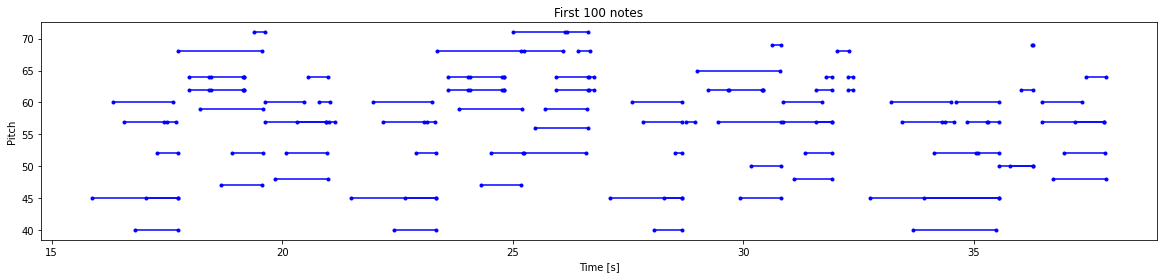

In [82]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

plot_piano_roll(raw_notes, count=100)

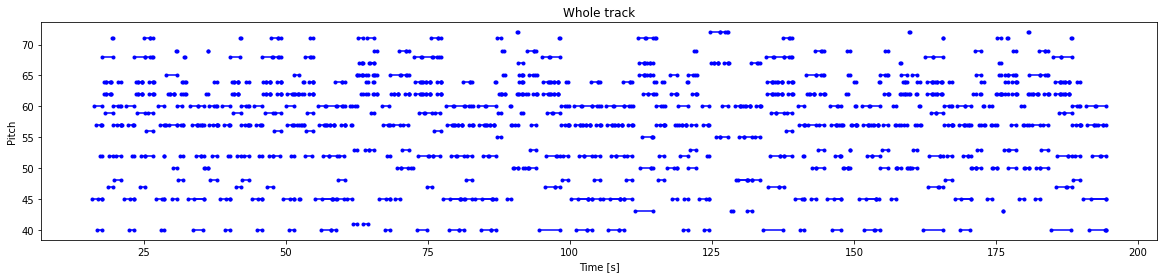

In [83]:
plot_piano_roll(raw_notes)

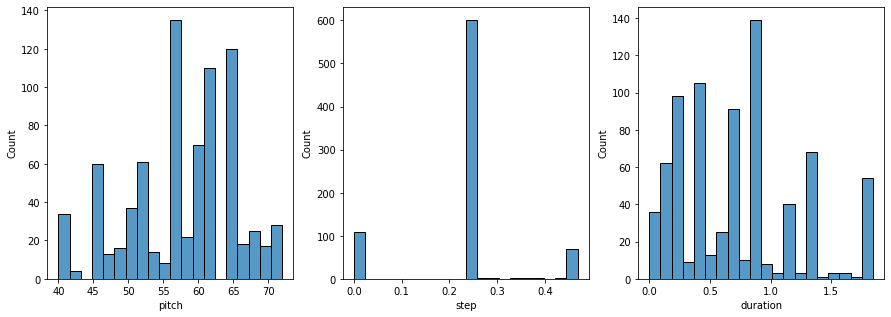

In [84]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

plot_distributions(raw_notes)

In [107]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 75,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

example_file = 'example.midi'
example_pm = notes_to_midi(
  raw_notes, out_file=example_file, instrument_name=instrument_name)

display_audio(example_pm)

In [111]:
num_files = 15
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)


Number of notes parsed: 12164


In [113]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [114]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)


In [115]:
seq_length = 100
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(100, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [116]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)


sequence shape: (100, 3)
sequence elements (first 10): tf.Tensor(
[[0.390625   0.         0.0999999 ]
 [0.296875   0.         0.10555545]
 [0.4453125  0.00555555 0.0999999 ]
 [0.484375   0.         0.111111  ]
 [0.421875   0.         0.111111  ]
 [0.390625   0.03888885 0.0555555 ]
 [0.296875   0.         0.06111105]
 [0.4453125  0.         0.06111105]
 [0.484375   0.         0.07222215]
 [0.421875   0.         0.07222215]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=50.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.3833329499999998>}


In [117]:
batch_size = 32
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

train_ds.element_spec

(TensorSpec(shape=(32, 100, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(32,), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(32,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(32,), dtype=tf.float64, name=None)})

In [118]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)


input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100, 3)]     0           []                               
                                                                                                  
 lstm_3 (LSTM)                  (None, 128)          67584       ['input_4[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm_3[0][0]']                 
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm_3[0][0]']                 
                                                                                            

In [119]:
losses = model.evaluate(train_ds, return_dict=True)
losses

377/377 [==============================] - 16s 34ms/step - loss: 7.7796 - duration_loss: 0.4476 - pitch_loss: 4.8624 - step_loss: 2.4696


{'duration_loss': 0.44761136174201965,
 'loss': 7.7796173095703125,
 'pitch_loss': 4.862419128417969,
 'step_loss': 2.4695849418640137}

In [120]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.025,
        'step': 0.05,
        'duration':1.0,
    },
    optimizer=optimizer,
)
model.evaluate(train_ds, return_dict=True)


377/377 [==============================] - 14s 34ms/step - loss: 0.6927 - duration_loss: 0.4476 - pitch_loss: 4.8624 - step_loss: 2.4696


{'duration_loss': 0.44761136174201965,
 'loss': 0.6926515102386475,
 'pitch_loss': 4.862419128417969,
 'step_loss': 2.4695849418640137}

In [122]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]
epochs = 30

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)


Epoch 1/30
377/377 [==============================] - 35s 93ms/step - loss: 0.3015 - duration_loss: 0.1034 - pitch_loss: 3.4789 - step_loss: 2.2230
Epoch 2/30
377/377 [==============================] - 35s 92ms/step - loss: 0.2834 - duration_loss: 0.0943 - pitch_loss: 3.1755 - step_loss: 2.1958
Epoch 3/30
377/377 [==============================] - 34s 91ms/step - loss: 0.2766 - duration_loss: 0.0919 - pitch_loss: 3.0866 - step_loss: 2.1522
Epoch 4/30
377/377 [==============================] - 34s 91ms/step - loss: 0.2743 - duration_loss: 0.0915 - pitch_loss: 3.0875 - step_loss: 2.1129
Epoch 5/30
377/377 [==============================] - 34s 91ms/step - loss: 0.2684 - duration_loss: 0.0880 - pitch_loss: 3.0110 - step_loss: 2.1023
Epoch 6/30
377/377 [==============================] - 34s 91ms/step - loss: 0.2618 - duration_loss: 0.0856 - pitch_loss: 2.9505 - step_loss: 2.0477
Epoch 7/30
377/377 [==============================] - 34s 91ms/step - loss: 0.2524 - duration_loss: 0.0814 - pit

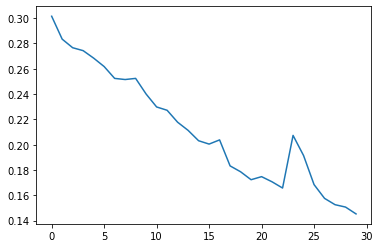

In [123]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()


In [124]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)


In [125]:
temperature = 2.0
num_predictions = 240

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))


In [126]:
generated_notes.head(10)


,pitch,step,duration,start,end
0,48,0.287912,0.293901,0.287912,0.581812
1,71,0.973455,1.632221,1.261367,2.893588
2,73,1.221325,1.772502,2.482692,4.255194
3,71,1.282095,1.777325,3.764787,5.542111
4,73,1.285658,1.778539,5.050445,6.828984
5,71,1.292420,1.778238,6.342865,8.121103
6,75,1.287646,1.778829,7.630512,9.409341
7,79,1.299330,1.778172,8.929842,10.708013
8,69,1.307757,1.776925,10.237598,12.014523
9,74,1.283079,1.779380,11.520677,13.300057


In [127]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)
